In [514]:
from sklearn import cluster
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score

In [162]:
G = nx.karate_club_graph()

pos = nx.spring_layout(G)

In [522]:
def draw_communities(G, membership, pos):
    """Draws the nodes to a plot with assigned colors for each individual cluster
    Parameters
    ----------
    G : networkx graph
    membership : list
        A list where the position is the student and the value at the position is the student club membership.
        E.g. `print(membership[8]) --> 1` means that student #8 is a member of club 1.
    pos : positioning as a networkx spring layout
        E.g. nx.spring_layout(G)
    """ 
    fig, ax = plt.subplots(figsize=(16,9))
    
    # Convert membership list to a dict where key=club, value=list of students in club
    club_dict = defaultdict(list)
    for student, club in enumerate(membership):
        club_dict[club].append(student)
    
    # Normalize number of clubs for choosing a color
    norm = colors.Normalize(vmin=0, vmax=len(club_dict.keys()))
    
    for club, members in club_dict.items():
        nx.draw_networkx_nodes(G, pos,
                               nodelist=members,
                               node_color=cm.jet(norm(club)),
                               node_size=500,
                               alpha=0.8,
                               ax=ax)

    # Draw edges (social connections) and show final plot
    plt.title("Zachary's Karate Club")
    nx.draw_networkx_edges(G, pos, alpha=0.5, ax=ax)

In [523]:
# True labels of the group each student (node) unded up in. Found via the original paper
y_true = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

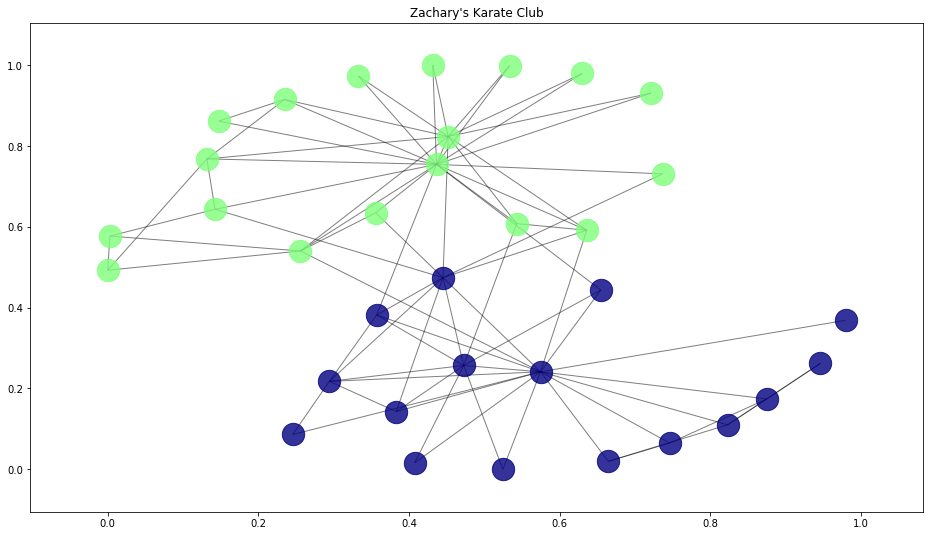

In [524]:
draw_communities(G, y_true, pos)

In [436]:
def graph_to_edge_matrix(G):
    """Convert a networkx graph into an edge matrix.
    See https://www.wikiwand.com/en/Incidence_matrix for a good explaination on edge matrices
   
    Parameters
    ----------
    G : networkx graph
    """
    # Initialize edge matrix with zeros
    edge_mat = np.zeros((len(G), len(G)), dtype=int)

    # Loop to set 0 or 1 (diagonal elements are set to 1)
    for node in G:
        for neighbor in G.neighbors(node):
            edge_mat[node][neighbor] = 1
        edge_mat[node][node] = 1

    return edge_mat

In [437]:
edge_mat = graph_to_edge_matrix(G)
edge_mat

array([[1, 1, 1, ..., 1, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 1, 0],
       ..., 
       [1, 0, 0, ..., 1, 1, 1],
       [0, 0, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])

In [438]:
k_clusters = 2
results = []
algorithms = {}

algorithms['kmeans'] = cluster.KMeans(n_clusters=k_clusters, n_init=200)

algorithms['agglom'] = cluster.AgglomerativeClustering(n_clusters=k_clusters, linkage="ward")

algorithms['spectral'] = cluster.SpectralClustering(n_clusters=k_clusters, affinity="precomputed", n_init=200)

algorithms['affinity'] = cluster.AffinityPropagation(damping=0.6)

for model in algorithms.values():
    model.fit(edge_mat)
    results.append(list(model.labels_))

In [439]:
# Check to see how many cluster the affinity propagation algo thinks there is
cluster_centers_indices = algorithms['affinity'].cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
print(n_clusters_)

8


In [440]:
# The resulting clubs
algorithms['affinity'].labels_

array([0, 2, 2, 2, 1, 1, 1, 2, 4, 3, 1, 1, 2, 2, 4, 4, 1, 2, 4, 4, 4, 2, 4,
       6, 5, 5, 6, 3, 3, 6, 4, 5, 7, 7], dtype=int64)

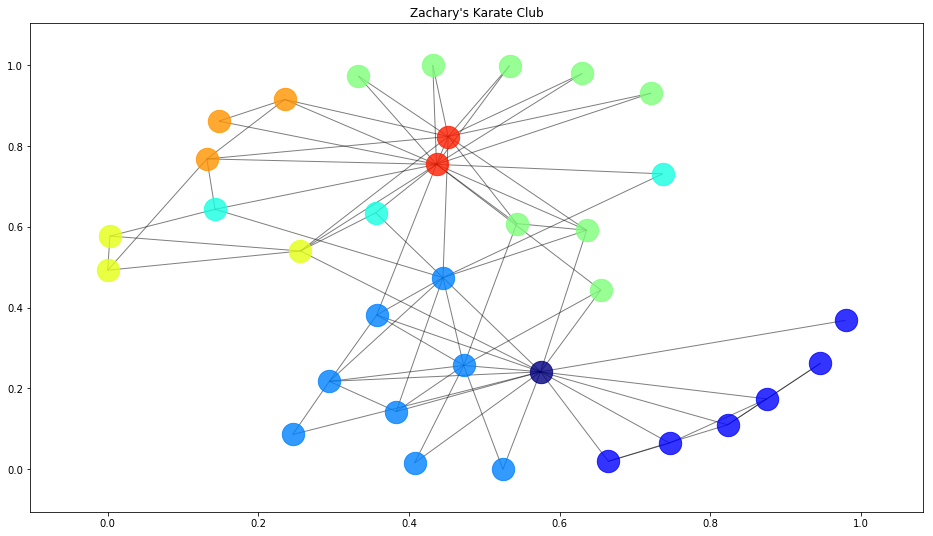

In [525]:
draw_communities(G, algorithms['affinity'].labels_, pos)

In [261]:
algorithms['kmeans'].labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [262]:
nmi_results = []
ars_results = []

y_true_val = list(y_true.values()

# Append the results into lists
for y_pred in results:
    nmi_results.append(normalized_mutual_info_score(y_true_val, y_pred))
    ars_results.append(adjusted_rand_score(y_true_val, y_pred))

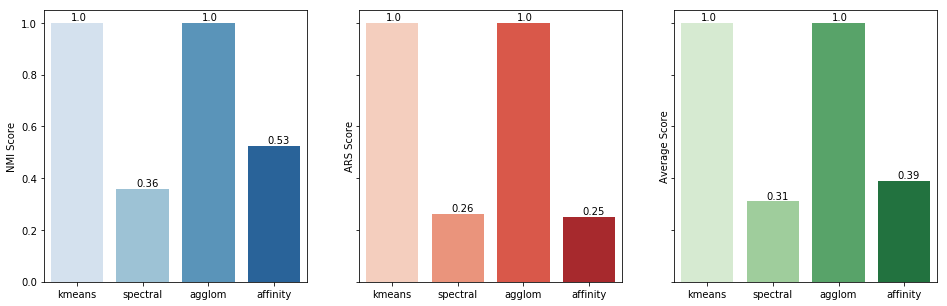

In [309]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(16, 5))

x = np.arange(len(y))
avg = [sum(x) / 2 for x in zip(nmi_results, ars_results)]

xlabels = list(algorithms.keys())

sns.barplot(x, nmi_results, palette='Blues', ax=ax1)
sns.barplot(x, ars_results, palette='Reds', ax=ax2)
sns.barplot(x, avg, palette='Greens', ax=ax3)

ax1.set_ylabel('NMI Score')
ax2.set_ylabel('ARS Score')
ax3.set_ylabel('Average Score')

# # Add the xlabels to the chart
ax1.set_xticklabels(xlabels)
ax2.set_xticklabels(xlabels)
ax3.set_xticklabels(xlabels)

# Add the actual value on top of each bar
for i, v in enumerate(zip(nmi_results, ars_results, avg)):
    ax1.text(i - 0.1, v[0] + 0.01, str(round(v[0], 2)))
    ax2.text(i - 0.1, v[1] + 0.01, str(round(v[1], 2)))
    ax3.text(i - 0.1, v[2] + 0.01, str(round(v[2], 2)))

# Show the final plot
plt.show()

In [353]:
def draw_true_vs_pred(G, y_true, y_pred, pos, algo_name, ax):
    
    for student, club in y_true.items():
        if y_pred is not None:
            if club == y_pred[student]:
                node_color = [0, 1, 0]
                node_shape = 'o'
            else:
                node_color = [0, 0, 0]
                node_shape = 'X'
                
        nx.draw_networkx_nodes(G, pos,
                               nodelist=[student],
                               node_color=node_color,
                               node_size=250,
                               alpha=0.7,
                               ax=ax,
                               node_shape=node_shape)
    
    # Draw edges and show final plot
    ax.set_title(algo_name)
    nx.draw_networkx_edges(G, pos, alpha=0.5, ax=ax)

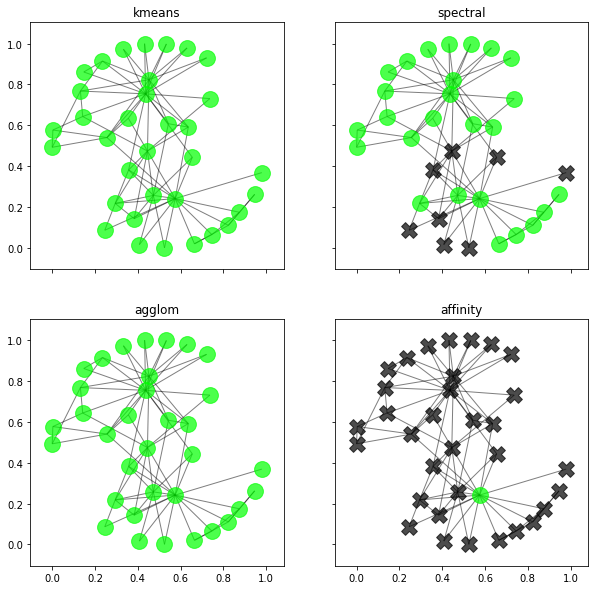

In [354]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 10))

for algo_name, ax in zip(algorithms.keys(), [ax1, ax2, ax3, ax4]):
    draw_true_vs_pred(G, y_true, algorithms[algo_name].labels_, pos, algo_name, ax)